In [17]:
!pip install -q tensorflow tensorflow-datasets

import os, math, random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# --- Reproducibility ---
SEED = 1337
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.config.experimental.enable_op_determinism()

# --- Config ---
IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# --- Load Oxford Flowers 102 ---
(ds_train_raw, ds_val_raw, ds_test_raw), info = tfds.load(
    "oxford_flowers102",
    split=["train", "validation", "test"],
    as_supervised=True,
    with_info=True,
)

NUM_CLASSES = info.features["label"].num_classes

print("TF:", tf.__version__)
print("TFDS:", tfds.__version__)
print("Classes:", NUM_CLASSES)

# --- Preprocess + Augment ---
preprocess_input = tf.keras.applications.resnet.preprocess_input  # clean, no squiggle

aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=SEED),
    tf.keras.layers.RandomRotation(0.05, seed=SEED),
    tf.keras.layers.RandomZoom(0.1, seed=SEED),
    tf.keras.layers.RandomContrast(0.05, seed=SEED),
])

def _prep(x, y):
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE), method="bicubic")
    x = tf.cast(x, tf.float32)   # keep 0..255 floats
    x = preprocess_input(x)      # ResNet preprocessing
    return x, y

def _aug(x, y):
    return aug(x, training=True), y

def build_train(ds):
    return (
        ds.map(_prep, num_parallel_calls=AUTOTUNE)
          .map(_aug, num_parallel_calls=AUTOTUNE)
          .shuffle(1024, seed=SEED)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE)
    )

def build_eval(ds):
    return (
        ds.map(_prep, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE)
    )

ds_train = build_train(ds_train_raw)
ds_val   = build_eval(ds_val_raw)
ds_test  = build_eval(ds_test_raw)

print("Data pipeline ready.")


TF: 2.20.0
TFDS: 4.9.9
Classes: 102
Data pipeline ready.


In [18]:
import tensorflow as tf

NUM_CLASSES = 102  # ensure defined

base = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3, seed=SEED)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
import tensorflow as tf

ModelCheckpoint   = tf.keras.callbacks.ModelCheckpoint
EarlyStopping     = tf.keras.callbacks.EarlyStopping
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau

EPOCHS1, EPOCHS2 = 8, 12
LR1, LR2 = 1e-3, 1e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR1),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks1 = [
    ModelCheckpoint("stage1_best.keras", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=5e-6),
]

print("Compile ready.")


Compile ready.


In [15]:
# Repair cell: ensure ds_train/ds_val/ds_test/NUM_CLASSES exist
import tensorflow as tf, tensorflow_datasets as tfds

# Keep existing settings if already defined
IMG_SIZE   = 224 if 'IMG_SIZE'   not in globals() else IMG_SIZE
BATCH_SIZE = 64  if 'BATCH_SIZE' not in globals() else BATCH_SIZE
SEED       = 1337 if 'SEED'      not in globals() else SEED
AUTOTUNE   = tf.data.AUTOTUNE

def _prep(x,y):
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE), method="bicubic")
    x = tf.clip_by_value(x, 0, 255)
    x = tf.cast(x, tf.float32)/255.0
    return x,y

aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=SEED),
    tf.keras.layers.RandomRotation(0.05, seed=SEED),
    tf.keras.layers.RandomZoom(0.1, seed=SEED),
    tf.keras.layers.RandomContrast(0.05, seed=SEED),
])

def _aug(x,y): return aug(x, training=True), y
def build_train(ds): return ds.shuffle(8192, seed=SEED).map(_prep, AUTOTUNE).map(_aug, AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
def build_eval(ds):  return ds.map(_prep, AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

if 'ds_train' not in globals() or 'ds_val' not in globals() or 'ds_test' not in globals() or 'NUM_CLASSES' not in globals():
    (ds_train_raw, ds_val_raw, ds_test_raw), info = tfds.load(
        "oxford_flowers102",
        split=["train","validation","test"],
        as_supervised=True,
        with_info=True,
        try_gcs=True,
        data_dir="/content/tfds",
    )
    ds_train = build_train(ds_train_raw)
    ds_val   = build_eval(ds_val_raw)
    ds_test  = build_eval(ds_test_raw)
    NUM_CLASSES = info.features["label"].num_classes

print("Ready ->",
      "ds_train" in globals(),
      "ds_val" in globals(),
      "ds_test" in globals(),
      "NUM_CLASSES" in globals())


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/tfds/oxford_flowers102/incomplete.U3QM9E_2.1.1/oxford_flowers102-train.tfrecord*...:   0%| …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/tfds/oxford_flowers102/incomplete.U3QM9E_2.1.1/oxford_flowers102-test.tfrecord*...:   0%|  …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/tfds/oxford_flowers102/incomplete.U3QM9E_2.1.1/oxford_flowers102-validation.tfrecord*...:  …

Dataset oxford_flowers102 downloaded and prepared to /content/tfds/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Ready -> True True True True


In [22]:
# Cell 5 — Train (Stage 1) + Fine-tune (Stage 2) + Eval + Save
import tensorflow as tf

# -------- Stage 1: train head (base frozen) --------
history1 = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS1,          # from Cell 3 (e.g., 8)
    callbacks=callbacks1,    # from Cell 3
)

# -------- Stage 2: unfreeze last 50 layers; keep BatchNorm frozen --------
base.trainable = True
for layer in base.layers[:-50]:
    layer.trainable = False
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile with lower LR for fine-tuning (make sure LR2=1e-4 in Cell 3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR2),   # e.g., LR2 = 1e-4
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Optional: log LR each epoch so you can SEE it's 0.0001 in Stage 2
lr_logger = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda e, logs: print(
        f"Stage 2 — Epoch {e+1}: LR={tf.keras.backend.get_value(model.optimizer.learning_rate):.6f}"
    )
)

callbacks2 = [
    tf.keras.callbacks.ModelCheckpoint("stage2_best.keras", save_best_only=True, monitor="val_accuracy"),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    lr_logger,
]

history2 = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS2,          # from Cell 3 (e.g., 12)
    callbacks=callbacks2,
)

# -------- Final test + save --------
test_metrics = model.evaluate(ds_test, return_dict=True)
print("Test metrics:", test_metrics)

model.save("flowers102_resnet50_finetuned.keras")
print("Saved: flowers102_resnet50_finetuned.keras")


Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 478s 29s/step - accuracy: 0.9280 - loss: 0.2444 - val_accuracy: 0.6284 - val_loss: 1.6398 - learning_rate: 1.0000e-04
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 505s 31s/step - accuracy: 0.9576 - loss: 0.1373 - val_accuracy: 0.6716 - val_loss: 1.4344 - learning_rate: 1.0000e-04
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 532s 29s/step - accuracy: 0.9782 - loss: 0.0927 - val_accuracy: 0.6510 - val_loss: 1.8714 - learning_rate: 1.0000e-04
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 510s 31s/step - accuracy: 0.9723 - loss: 0.0859 - val_accuracy: 0.6912 - val_loss: 1.3649 - learning_rate: 1.0000e-04
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 505s 31s/step - accuracy: 0.9778 - loss: 0.0717 - val_accuracy: 0.6735 - val_loss: 1.4705 - learning_rate: 1.0000e-04
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 474s 29s/step - accuracy: 0.9901 - loss: 0.0551 - val_accuracy: 0.7314 - val_loss: 1.1152 - learning_rate: 1.0000e-04
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 515s 32s/step - accuracy: 0.9913 

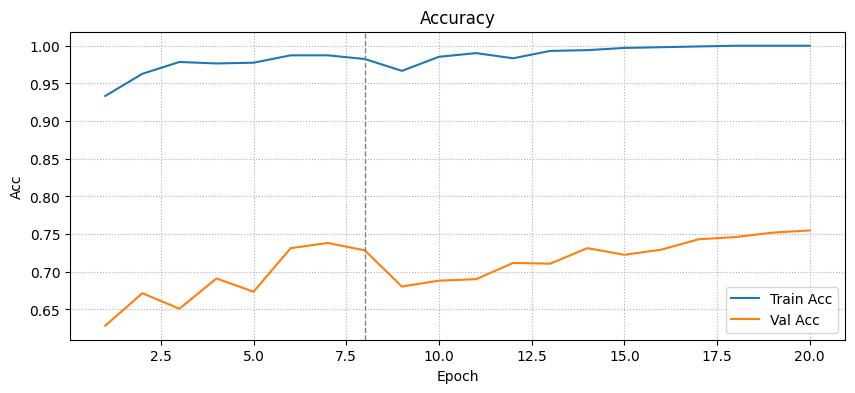

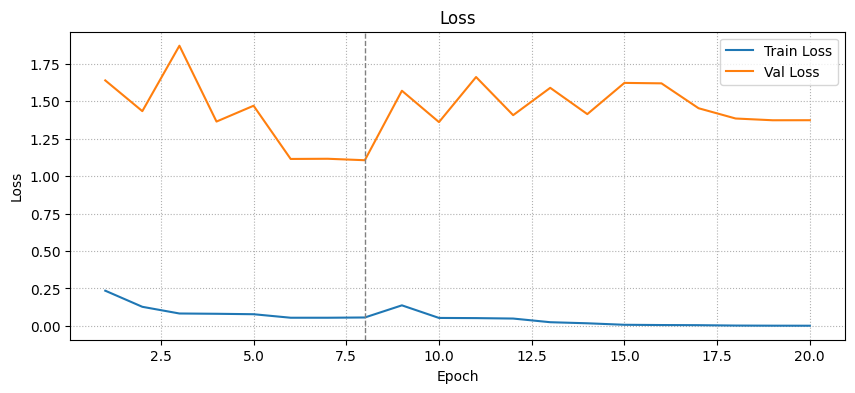

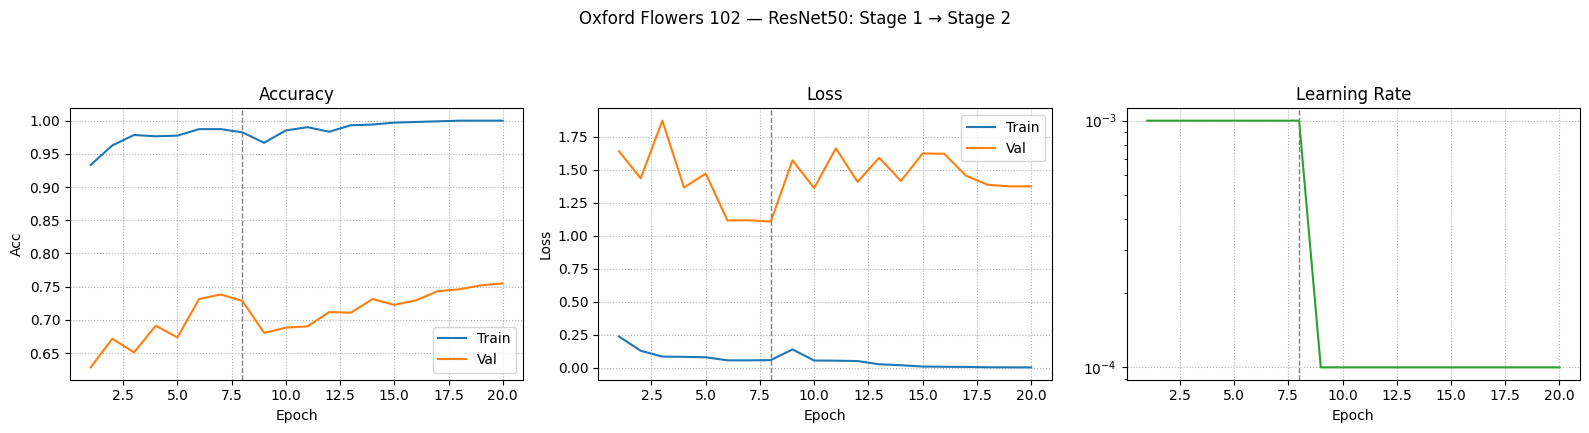

Best val_acc: 0.7549 at epoch 20


In [23]:
# Cell 6 — Curves: Accuracy, Loss, Learning Rate (separate + combined)
import numpy as np, matplotlib.pyplot as plt

# Merge histories
acc      = history1.history["accuracy"]     + history2.history["accuracy"]
val_acc  = history1.history["val_accuracy"] + history2.history["val_accuracy"]
loss     = history1.history["loss"]         + history2.history["loss"]
val_loss = history1.history["val_loss"]     + history2.history["val_loss"]
epochs = np.arange(1, len(acc) + 1)
split  = len(history1.history["accuracy"])   # where Stage 2 starts

# Learning rate per epoch (fallback to LR1/LR2 if not recorded)
def _lrs_from_history(h, fallback_lr):
    return h.get("lr", [fallback_lr] * len(h["loss"]))
lrs = _lrs_from_history(history1.history, LR1) + _lrs_from_history(history2.history, LR2)

# --- Accuracy (separate) ---
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.axvline(split, ls="--", color="gray", lw=1)
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.grid(ls=":"); plt.legend()
plt.show()

# --- Loss (separate) ---
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.axvline(split, ls="--", color="gray", lw=1)
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(ls=":"); plt.legend()
plt.show()

# --- Combined 3-panel (Acc, Loss, LR) ---
fig, axes = plt.subplots(1, 3, figsize=(16,4), sharex=True)
ax1, ax2, ax3 = axes
ax1.plot(epochs, acc, label="Train"); ax1.plot(epochs, val_acc, label="Val")
ax1.axvline(split, ls="--", color="gray", lw=1)
ax1.set_title("Accuracy"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Acc"); ax1.grid(ls=":"); ax1.legend()

ax2.plot(epochs, loss, label="Train"); ax2.plot(epochs, val_loss, label="Val")
ax2.axvline(split, ls="--", color="gray", lw=1)
ax2.set_title("Loss"); ax2.set_xlabel("Epoch"); ax2.set_ylabel("Loss"); ax2.grid(ls=":"); ax2.legend()

ax3.plot(epochs, lrs, color="#2ca02c")
ax3.axvline(split, ls="--", color="gray", lw=1)
ax3.set_title("Learning Rate"); ax3.set_xlabel("Epoch"); ax3.set_yscale("log"); ax3.grid(ls=":")
fig.suptitle("Oxford Flowers 102 — ResNet50: Stage 1 → Stage 2", y=1.07)
plt.tight_layout(); plt.show()

# Quick best epoch print
best_epoch = int(np.argmax(val_acc)) + 1
print(f"Best val_acc: {max(val_acc):.4f} at epoch {best_epoch}")


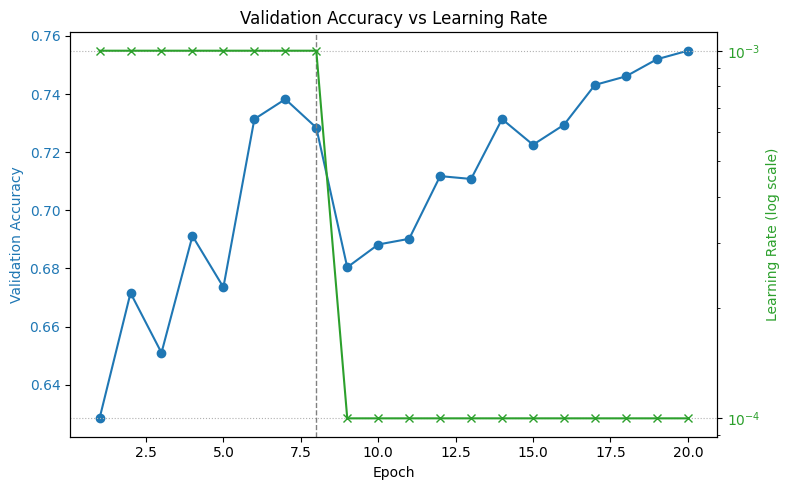

In [24]:
# Cell 7 — Validation Accuracy vs Learning Rate (Twin Axes)

fig, ax1 = plt.subplots(figsize=(8,5))

epochs = np.arange(1, len(val_acc) + 1)

# Plot validation accuracy on left axis
ax1.plot(epochs, val_acc, color="#1f77b4", marker="o", label="Val Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Accuracy", color="#1f77b4")
ax1.tick_params(axis="y", labelcolor="#1f77b4")

# Twin axis for learning rate
ax2 = ax1.twinx()
ax2.plot(epochs, lrs, color="#2ca02c", marker="x", label="Learning Rate")
ax2.set_ylabel("Learning Rate (log scale)", color="#2ca02c")
ax2.set_yscale("log")
ax2.tick_params(axis="y", labelcolor="#2ca02c")

# Add stage-split marker
ax1.axvline(split, ls="--", color="gray", lw=1)

# Title and grid
plt.title("Validation Accuracy vs Learning Rate")
fig.tight_layout()
plt.grid(ls=":")

plt.show()


In [25]:
# Cell 8 — Export plots + models to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os, time, shutil, glob
import numpy as np, matplotlib.pyplot as plt

# ---- Output folder in Drive ----
STAMP = time.strftime("%Y-%m-%d_%H-%M-%S")
SAVE_DIR = f"/content/drive/MyDrive/flowers102_run_{STAMP}"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---- Rebuild curves from histories ----
acc      = history1.history["accuracy"]     + history2.history["accuracy"]
val_acc  = history1.history["val_accuracy"] + history2.history["val_accuracy"]
loss     = history1.history["loss"]         + history2.history["loss"]
val_loss = history1.history["val_loss"]     + history2.history["val_loss"]
epochs   = np.arange(1, len(acc) + 1)
split    = len(history1.history["accuracy"])

# Learning rate per epoch (fallback to LR1/LR2 if not recorded)
def _lrs(h, fallback): return h.get("lr", [fallback] * len(h["loss"]))
lrs = _lrs(history1.history, LR1) + _lrs(history2.history, LR2)

# ---- Accuracy (PNG+PDF) ----
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.axvline(split, ls="--", color="gray", lw=1)
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(ls=":"); plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "accuracy.png"), dpi=180, bbox_inches="tight")
plt.savefig(os.path.join(SAVE_DIR, "accuracy.pdf"), bbox_inches="tight")
plt.close()

# ---- Loss (PNG+PDF) ----
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.axvline(split, ls="--", color="gray", lw=1)
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(ls=":"); plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "loss.png"), dpi=180, bbox_inches="tight")
plt.savefig(os.path.join(SAVE_DIR, "loss.pdf"), bbox_inches="tight")
plt.close()

# ---- Combined 3-panel (Acc, Loss, LR) ----
fig, axes = plt.subplots(1, 3, figsize=(16,4), sharex=True)
ax1, ax2, ax3 = axes
ax1.plot(epochs, acc, label="Train"); ax1.plot(epochs, val_acc, label="Val")
ax1.axvline(split, ls="--", color="gray", lw=1); ax1.set_title("Accuracy"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Acc"); ax1.grid(ls=":"); ax1.legend()
ax2.plot(epochs, loss, label="Train"); ax2.plot(epochs, val_loss, label="Val")
ax2.axvline(split, ls="--", color="gray", lw=1); ax2.set_title("Loss"); ax2.set_xlabel("Epoch"); ax2.set_ylabel("Loss"); ax2.grid(ls=":"); ax2.legend()
ax3.plot(epochs, lrs, color="#2ca02c"); ax3.axvline(split, ls="--", color="gray", lw=1)
ax3.set_title("Learning Rate"); ax3.set_xlabel("Epoch"); ax3.set_yscale("log"); ax3.grid(ls=":")
fig.suptitle("Oxford Flowers 102 — ResNet50 (Stage 1 → Stage 2)", y=1.06)
fig.tight_layout()
fig.savefig(os.path.join(SAVE_DIR, "combined_acc_loss_lr.png"), dpi=180, bbox_inches="tight")
fig.savefig(os.path.join(SAVE_DIR, "combined_acc_loss_lr.pdf"), bbox_inches="tight")
plt.close(fig)

# ---- Twin-axes: Val Acc vs LR (PNG+PDF) ----
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()
ax1.plot(epochs, val_acc, color="#d62728", label="Val Acc")
ax2.plot(epochs, lrs, color="#2ca02c", label="LR", alpha=0.8)
ax1.axvline(split, ls="--", color="gray", lw=1)
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Val Acc", color="#d62728"); ax1.tick_params(axis="y", labelcolor="#d62728")
ax2.set_ylabel("LR (log)", color="#2ca02c"); ax2.set_yscale("log"); ax2.tick_params(axis="y", labelcolor="#2ca02c")
ax1.grid(ls=":")
fig.tight_layout()
fig.savefig(os.path.join(SAVE_DIR, "valacc_vs_lr.png"), dpi=180, bbox_inches="tight")
fig.savefig(os.path.join(SAVE_DIR, "valacc_vs_lr.pdf"), bbox_inches="tight")
plt.close(fig)

# ---- Run summary ----
best_epoch = int(np.argmax(val_acc)) + 1
with open(os.path.join(SAVE_DIR, "run_summary.txt"), "w") as f:
    f.write(
        "Oxford Flowers 102 — ResNet50 (TFDS/Colab)\n"
        f"Stage1 epochs: {len(history1.history['loss'])}\n"
        f"Stage2 epochs: {len(history2.history['loss'])}\n"
        f"Best val_acc:  {max(val_acc):.4f} at epoch {best_epoch}\n"
    )

# ---- Copy model checkpoints if present ----
for f in glob.glob("*.keras"):
    shutil.copy2(f, os.path.join(SAVE_DIR, os.path.basename(f)))

print("Exported to:", SAVE_DIR)


MessageError: Error: credential propagation was unsuccessful

In [27]:
from google.colab import auth
auth.authenticate_user()


In [28]:
# Zip all outputs and download (no Google Drive needed)
import os, glob, zipfile, io
from google.colab import files

# What to include (add/remove patterns if you want)
patterns = ["*.keras", "*.png", "*.pdf", "run_summary.txt", "*.json", "*.csv"]

to_pack = []
for p in patterns:
    to_pack.extend(glob.glob(p))

if not to_pack:
    print("Nothing matched — adjust patterns or run your plotting cells first.")
else:
    zname = "flowers102_export.zip"
    with zipfile.ZipFile(zname, "w", compression=zipfile.ZIP_DEFLATED) as z:
        for f in sorted(set(to_pack)):
            z.write(f)
            print("added:", f)

    print("\nCreated:", zname, "size:", os.path.getsize(zname)/1e6, "MB")
    files.download(zname)  # browser download


added: flowers102_resnet50_finetuned.keras
added: stage1_best.keras
added: stage2_best.keras

Created: flowers102_export.zip size: 648.247022 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import nbformat, os, pathlib

# path to your current notebook (Colab sets this name automatically when you saved it)
src = "/content/Oxford_Flowers_102_ResNet50_FORGE_Colab.ipynb"
dst = "/content/Oxford_Flowers_102_ResNet50_FORGE_clean.ipynb"

nb = nbformat.read(src, as_version=4)

# remove widget metadata that breaks GitHub rendering
nb.metadata.pop("widgets", None)
for cell in nb.cells:
    if hasattr(cell, "metadata"):
        cell.metadata.pop("widgets", None)

nbformat.write(nb, dst)
print("Wrote:", dst, "size:", pathlib.Path(dst).stat().st_size, "bytes")


FileNotFoundError: [Errno 2] No such file or directory: '/content/Oxford_Flowers_102_ResNet50_FORGE_Colab.ipynb'